In [1]:
%matplotlib inline

This notebook is aimed at getting all the effector candidates from the Pst_104E_genome as defined as the following.

Gene expression cluster analysis done by Jana Sperschneider cluster 8

In [2]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#define your input folders
CLUSTER_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/gene_expression/Pst104_p_SecretomeClustering'
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Pst_104E_genome/Secretomes/EffectorP'
GFF_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/pa_26062017'
OUT_FOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists'

In [4]:
genome = 'Pst_104E_v12_'
p_effector_list = []
h_effector_list = []

In [5]:
#define what you want to take from the cluster folder or else adapt here
clusters = [ 8]
clusters_files = [os.path.join(CLUSTER_FOLDER, x) for x in os.listdir(CLUSTER_FOLDER)\
                 if x.startswith('Cluster') and x.endswith('_DEs.fasta') and int(x[7]) in clusters ]


In [6]:
#get all the sequence names into a list from the fasta headers 
for file in clusters_files:
    fh = open(file, 'r')
    for seq in SeqIO.parse(fh, 'fasta'):
        if 'hcontig' in seq.id:
            h_effector_list.append(seq.id)
        if 'pcontig' in seq.id:
            p_effector_list.append(seq.id)
    fh.close()

Change filename below to alter what to look at

In [7]:
#this will be the newly created file in the list folder and p_effector_file will be the variable
# for tracking the gene list
to_look_at = 'cluster_8.list'
p_effector_file = os.path.join(OUT_FOLDER, genome + to_look_at)


In [8]:
#write out the sets of effector candidates
fh = open(p_effector_file, 'w')
for ec in set(p_effector_list):
    print(ec, file=fh)
fh.close()

In [9]:
#subset the gff files as well 
#right now get this in
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('anno.gff3') ][0]
h_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'h_ctg') and x.endswith('anno.gff3') ][0]

In [10]:
#get repeat gff files from REPET (not sure this fully works right now)
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.gff') ][0]

In the command line in /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/TE_analysis the superfamily gff files were sorted as followed and copied over into the lists folder
sort Pst_104E_v12_h_ctg.REPET.superfamily.gff -k1,1n -k4,4n > Pst_104E_v12_h_ctg.REPET.sorted.superfamily.gff

In [11]:
#get repeat gff files with superfamilies in the 'attributes' column
p_repeat_superfamily_gff_fn = [os.path.join(OUT_FOLDER, x) for x in os.listdir(OUT_FOLDER)\
                 if x.startswith(genome+'p_ctg') and x.endswith('REPET.sorted.superfamily.gff') ][0]


In [12]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [13]:
#now subset the gff files for effectors only
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
#before that we need to convert the gene ids to protein ids in the attribute column
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)

In [14]:
os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )

'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_p_ctg.REPET.gff'

In [15]:
#now write out dataframes for p_gff

#bed 6 file
p_effector_bed_fn = p_effector_file.replace('.list', '.gene.bed') #generate filename
print(p_effector_bed_fn)
#save out subset p_gff_df using the p_effector_list as filter (defined above). Outformat is a bed file
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_effector_bed_fn, header=None, index=None, sep='\t')

#do the same and generate a gff file
p_effector_gff_fn = p_effector_file.replace('.list', '.gene.gff3')    
print(p_effector_gff_fn)
p_gff_df[(p_gff_df.type == 'gene') & (p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_effector_gff_fn, header=None, index=None, sep='\t')


#bed 6 file no effectors
p_noeffector_bed_fn = p_effector_file.replace(to_look_at, 'no_cluster_8.gene.bed')
print(p_noeffector_bed_fn)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,['seqid', 'start', 'end', 'ID', 'score', 'strand']].to_csv(p_noeffector_bed_fn, header=None, index=None, sep='\t')

#no effector gff and list
p_noeffector_gff_fn = p_effector_file.replace(to_look_at, 'no_cluster_8.gene.gff3')   
print(p_noeffector_gff_fn)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))].\
    loc[:,gff_header].to_csv(p_noeffector_gff_fn, header=None, index=None, sep='\t')

file_name = p_effector_file.replace(to_look_at, 'no_cluster_8.list')
print(file_name)
p_gff_df[(p_gff_df.type == 'gene') & (~p_gff_df.ID.str.replace('TU', 'model').isin(p_effector_list))]['ID'].str.replace('TU', 'model')\
    .to_csv(file_name, header=None, index=None, sep='\t')

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_cluster_8.gene.bed
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_cluster_8.gene.gff3
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.gene.bed
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.gene.gff3
/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/enrichment_analysis/lists/Pst_104E_v12_no_cluster_8.list


In [16]:
#get BUSCO file names to be used in the anaylsis these are also in the list folder (OUT_PATH)
p_busco_gff_fn = p_effector_file.replace(to_look_at, 'p_busco.gene.gff3')
p_busco_bed_fn = p_effector_file.replace(to_look_at, 'p_busco.gene.bed')


In [17]:
#get the gff for all genes
p_gene_gff_fn = p_effector_file.replace(to_look_at, 'p_all.gene.gff3')

#get bed 6 for all genes
p_gene_bed_fn = p_effector_file.replace(to_look_at, 'p_all.gene.bed')


In [18]:
#get the distances between genes and TEs

#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_effector_bed = BedTool(p_effector_gff_fn)
p_noeffector_bed = BedTool(p_noeffector_gff_fn)
p_busco_bed = BedTool(p_busco_gff_fn)
p_repeats_bed = BedTool(p_repeat_superfamily_gff_fn)

#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()

#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3199: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 19 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [19]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [20]:
import warnings
warnings.filterwarnings('ignore')

Effector distance to closest repeat
                 18
count    308.000000
mean    2117.555195
std     3066.023727
min        0.000000
25%        0.000000
50%      994.500000
75%     2586.250000
max    17811.000000


(0, 10000)

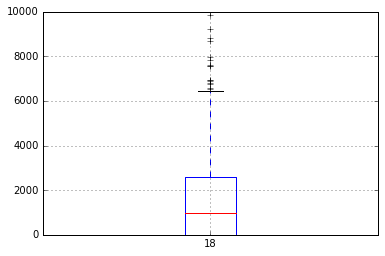

In [21]:
print('Effector distance to closest repeat')
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

BUSCO distance to closest repeat
                 18
count   1444.000000
mean    2938.963989
std     4085.483570
min        0.000000
25%      452.500000
50%     1321.000000
75%     3907.250000
max    41225.000000


(0, 10000)

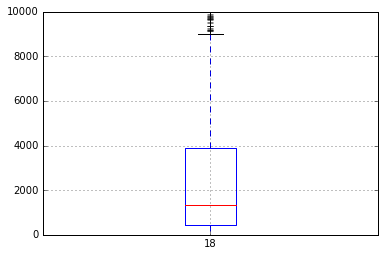

In [22]:
print('BUSCO distance to closest repeat')
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

No Effector distance to closest repeat
                 18
count  15587.000000
mean    2295.757169
std     3778.415387
min        0.000000
25%        0.000000
50%      799.000000
75%     2991.000000
max    55526.000000


(0, 10000)

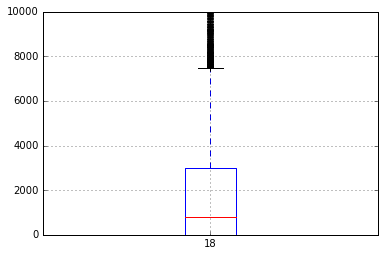

In [23]:
print('No Effector distance to closest repeat')
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)
plt.ylim(0, 10000)

In [24]:
#some stuff in the following lines

In [25]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_noeffector_bed)*100

17
ClassII:MITE:?                3.617157
ClassI:LTR:?                  3.918054
ClassII:TIR:PIF-Harbinger     4.455826
ClassII:TIR:Tc1-Mariner       4.711908
ClassII:TIR:hAT               8.482714
ClassI:LARD:?                 8.950064
ClassI:LTR:Copia              9.302177
ClassII:TIR:?                 9.929577
ClassII:?:?                  12.976953
ClassI:LTR:Gypsy             17.791293
Name: 0, dtype: float64

In [26]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_effector_bed)*100

17
noCat                       3.246753
ClassII:TIR:Tc1-Mariner     3.571429
ClassI:LTR:?                5.844156
ClassII:TIR:hAT             6.168831
ClassII:MITE:?              7.792208
ClassI:LTR:Copia            8.116883
ClassII:TIR:?               9.090909
ClassI:LARD:?               9.740260
ClassI:LTR:Gypsy           14.285714
ClassII:?:?                18.831169
Name: 0, dtype: float64

In [27]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().groupby(17).count()[0].sort_values().tail(10)/len(p_busco_bed)*100

17
ClassI:LTR:?                  4.362881
ClassII:TIR:PIF-Harbinger     4.432133
ClassII:TIR:Tc1-Mariner       5.401662
ClassII:MITE:?                5.747922
ClassI:LTR:Copia              7.963989
ClassII:TIR:hAT               8.518006
ClassI:LARD:?                10.526316
ClassII:TIR:?                12.119114
ClassI:LTR:Gypsy             13.573407
ClassII:?:?                  15.858726
Name: 0, dtype: float64

In [28]:
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:hAT             3189.162393
ClassII:?:Sola              3290.000000
ClassI:LTR:Gypsy            3528.756906
ClassII:TIR:Tc1-Mariner     3675.421053
ClassII:Helitron:?          3765.230769
ClassI:LINE:Jockey          3832.500000
ClassII:TIR:MuDR            3947.156250
ClassII:Maverick:?          4384.285714
ClassI:LTR:ERV              7696.000000
ClassII:?:Academ           10287.000000
Name: 18, dtype: float64

In [29]:
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassII:TIR:CACTA           2458.177083
ClassII:TIR:MuDR            2654.820734
ClassII:TIR:hAT             2677.529274
noCat                       2677.621333
ClassII:TIR:?               2783.694550
ClassII:TIR:Tc1-Mariner     2883.061798
ClassII:Helitron:?          2974.724359
ClassI:LINE:Jockey          3003.733333
ClassII:MITE:?              3302.210526
ClassI:LTR:ERV             10918.400000
Name: 18, dtype: float64

In [30]:
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().groupby(17).mean()[18].sort_values().tail(10)

17
ClassI:LTR:Gypsy      2037.925000
noCat                 2140.538462
ClassI:DIRS:DIRS      2537.000000
ClassII:Helitron:?    2703.333333
ClassI:LTR:Copia      3298.652174
ClassII:TIR:?         3331.035714
ClassII:Maverick:?    3639.500000
ClassII:TIR:hAT       3736.062500
ClassII:TIR:CACTA     3959.000000
ClassI:?:?            4535.000000
Name: 18, dtype: float64

In [31]:
#now lookine at ClassII:?:? specifically
tmp_REPET[(tmp_REPET.distance > 400)&(tmp_REPET.attributes == 'ClassII:?:?')].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

                  18
count     308.000000
mean    14867.250000
std     15499.382504
min        74.000000
25%      3726.750000
50%     10596.500000
75%     20149.500000
max    111250.000000


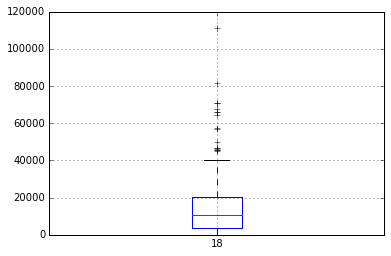

In [32]:
print(p_effector_bed.closest(p_repeats_bed,d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_effector_bed.closest(p_repeats_bed, d=True, t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count    1296.000000
mean    17249.780093
std     19339.281875
min         2.000000
25%      4185.000000
50%     11023.000000
75%     23301.250000
max    156673.000000


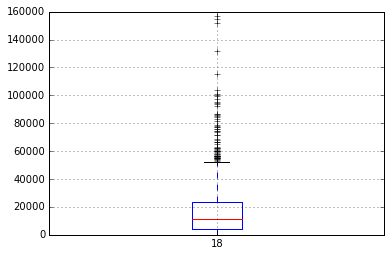

In [33]:
print(p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count    5798.000000
mean    15765.202484
std     17775.726928
min         2.000000
25%      4151.750000
50%     10118.500000
75%     21072.250000
max    187286.000000


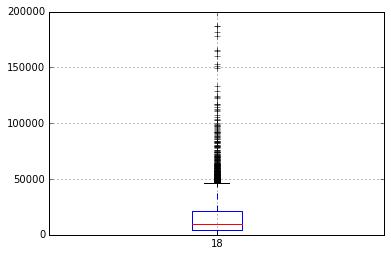

In [34]:
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().boxplot(column=18)

                  18
count   15024.000000
mean    17478.975905
std     20851.892868
min         0.000000
25%      4034.000000
50%     10868.500000
75%     23203.250000
max    194780.000000


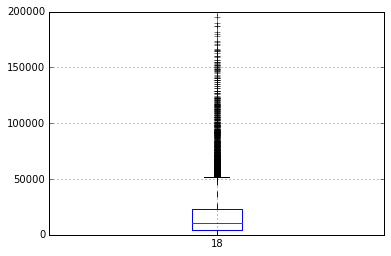

In [35]:
print(p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().iloc[:,18:20].describe())
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().boxplot(column=18)

In [36]:
#re-define the repeats here before looking into it with different perspective
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)
p_repeats_bed = BedTool(tmp_fn)

[]

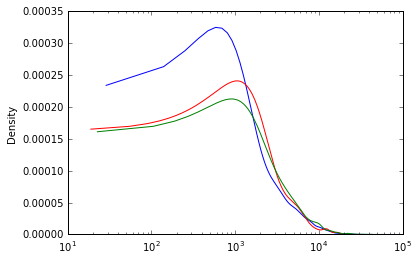

In [37]:
#densities without overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

[]

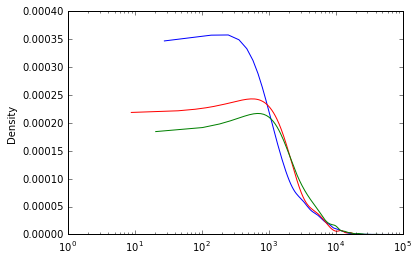

In [38]:
#densities with overlaps between repeats and genes
p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density')
p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='r')
p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe().loc[:,18].plot(kind='density', color='g')
plt.semilogx()

In [39]:
#define repeats
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily', 'tmpsuperfamily')
tmp_REPET[tmp_REPET.distance > 400].loc[:,gff_header].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [40]:
#summary of closest TEs not allowing for overlaps 
#####Needs fixing for genes that don't have a nearest neighbou######
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last', io=True).to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassI:DIRS:DIRS,distance,1798.99,1.28,2274.42,1.32,2582.60,1.62
ClassII:TIR:CACTA,distance,3321.01,2.32,6555.92,0.90,3441.20,1.62
ClassII:Helitron:?,distance,3265.39,0.97,4449.82,0.76,2703.33,1.95
ClassII:TIR:MuDR,distance,2961.89,3.13,4569.71,1.94,1571.62,2.60
ClassII:TIR:PIF-Harbinger,distance,1978.80,4.48,2674.48,4.43,2221.44,2.92
noCat,distance,2816.53,2.65,2771.70,2.08,2782.70,3.25
ClassII:TIR:Tc1-Mariner,distance,3171.57,4.74,3836.76,5.40,3333.45,3.57
ClassI:LTR:?,distance,2550.36,3.94,2769.40,4.36,2024.61,5.84
ClassII:TIR:hAT,distance,2927.14,8.54,3211.91,8.52,3677.32,6.17


In [41]:
#summary of closest TEs allowing for overlaps
p_br_closest_df = p_busco_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_br_closest_pt = p_br_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_br_closest_pt['superfamily_%'] = p_br_closest_pt.count_nonzero / p_br_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_br_closest_pt.columns] 
new_columns = [x+'_busco' for x in p_br_closest_pt.columns]
p_br_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_er_closest_df = p_effector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_er_closest_pt = p_er_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_er_closest_pt['superfamily_%'] = p_er_closest_pt.count_nonzero / p_er_closest_pt.count_nonzero.sum() *100
old_columns =[x for x in p_er_closest_pt.columns] 
new_columns = [x+'_effector' for x in p_er_closest_pt.columns]
p_er_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

p_ner_closest_df = p_noeffector_bed.closest(p_repeats_bed, d=True,t='last').to_dataframe(names = bed_repeat_closest_header)

p_ner_closest_pt = p_ner_closest_df.pivot_table(values='distance', index=['attributes_repeat'] ,aggfunc=[ np.count_nonzero, np.mean]).T.unstack().T

p_ner_closest_pt['superfamily_%'] = p_ner_closest_pt['count_nonzero'] / p_ner_closest_pt['count_nonzero'].sum() *100
old_columns =[x for x in p_ner_closest_pt.columns] 
new_columns = [x+'_noeffector' for x in p_ner_closest_pt.columns]
p_ner_closest_pt.rename(columns=dict(zip(old_columns,new_columns)), inplace = True)

pd.options.display.float_format = '{:.2f}'.format

repeat_distance_df = pd.concat([p_ner_closest_pt.iloc[:,1:], p_br_closest_pt.iloc[:,1:], p_er_closest_pt.iloc[:,1:]], axis=1)

repeat_distance_df[repeat_distance_df['superfamily_%_effector'] >1].sort_values('superfamily_%_effector')

,,mean_noeffector,superfamily_%_noeffector,mean_busco,superfamily_%_busco,mean_effector,superfamily_%_effector
attributes_repeat,,,,,,,
ClassI:DIRS:DIRS,distance,1478.37,1.07,2160.70,1.47,2537.00,1.33
ClassII:TIR:CACTA,distance,2458.18,1.82,2993.24,0.77,3959.00,1.78
ClassII:Helitron:?,distance,2974.72,1.18,3765.23,0.85,2703.33,2.67
ClassII:TIR:PIF-Harbinger,distance,1469.87,4.18,2284.90,4.26,1502.36,2.67
ClassII:TIR:MuDR,distance,2654.82,3.12,3947.16,2.09,1456.71,3.11
ClassII:TIR:Tc1-Mariner,distance,2883.06,4.94,3675.42,5.42,1535.27,3.11
noCat,distance,2677.62,2.79,2868.71,2.17,2140.54,4.44
ClassI:LARD:?,distance,2097.49,8.89,3156.92,9.83,1139.18,4.89
ClassI:LTR:?,distance,2235.78,3.89,2485.55,4.57,981.18,4.89


Add some sub_sets for randommization to get equal sized groups

In [42]:
#set the size of the subset here
sub_set = len(p_effector_bed)

In [43]:
p_effector_bed = BedTool(p_effector_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

count      290.00
mean     97968.61
std     135303.65
min       1314.00
25%      12738.00
50%      41225.00
75%     146234.75
max     964418.00
Name: Effectors, dtype: float64


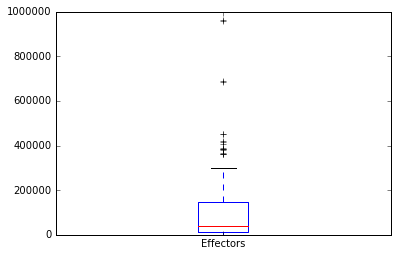

In [44]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1]
p_eself.name = 'Effectors'
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1]
print(p_eself.describe())
p_eself.plot(kind='box')

In [45]:
#some temp analysis
tmp_df = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe()

In [46]:
tmp_df[(tmp_df[12] < 36684) & (tmp_df[12] > -1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12
10,pcontig_001,498220,500173,evm.TU.pcontig_001.124,.,-,pcontig_001,512910,515514,evm.TU.pcontig_001.127,.,-,12738
11,pcontig_001,512910,515514,evm.TU.pcontig_001.127,.,-,pcontig_001,498220,500173,evm.TU.pcontig_001.124,.,-,12738
13,pcontig_001,803807,804812,evm.TU.pcontig_001.197,.,+,pcontig_001,816431,817520,evm.TU.pcontig_001.200,.,-,11620
14,pcontig_001,816431,817520,evm.TU.pcontig_001.200,.,-,pcontig_001,803807,804812,evm.TU.pcontig_001.197,.,+,11620
16,pcontig_001,1663502,1665663,evm.TU.pcontig_001.395,.,-,pcontig_001,1667080,1668750,evm.TU.pcontig_001.396,.,-,1418
17,pcontig_001,1667080,1668750,evm.TU.pcontig_001.396,.,-,pcontig_001,1663502,1665663,evm.TU.pcontig_001.395,.,-,1418
21,pcontig_002,96349,98306,evm.TU.pcontig_002.21,.,+,pcontig_002,134744,136657,evm.TU.pcontig_002.29,.,-,36439
22,pcontig_002,134744,136657,evm.TU.pcontig_002.29,.,-,pcontig_002,96349,98306,evm.TU.pcontig_002.21,.,+,36439
26,pcontig_002,1626991,1628251,evm.TU.pcontig_002.396,.,-,pcontig_002,1652140,1652582,evm.TU.pcontig_002.403,.,-,23890
27,pcontig_002,1652140,1652582,evm.TU.pcontig_002.403,.,-,pcontig_002,1626991,1628251,evm.TU.pcontig_002.396,.,-,23890


count      285.00
mean    132286.42
std     135014.70
min        759.00
25%      36651.00
50%      81028.00
75%     178600.00
max     707059.00
Name: All_genes, dtype: float64


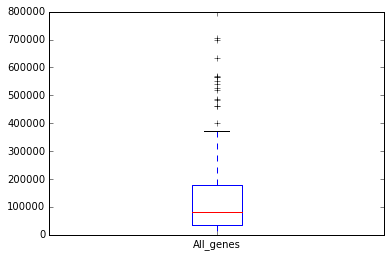

In [47]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
p_allall.name = 'All_genes'
print(p_allall.describe())
p_allall.plot(kind='box')

count      276.00
mean    125375.90
std     137071.52
min        536.00
25%      25623.25
50%      75881.50
75%     170959.00
max     688540.00
Name: BUSCO, dtype: float64


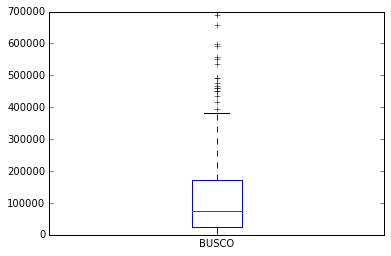

In [48]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
p_bself.name = 'BUSCO'
print(p_bself.describe())
p_bself.plot(kind='box')

count      280.00
mean    146777.51
std     163182.77
min        516.00
25%      40147.00
50%      90905.00
75%     175616.00
max     888462.00
Name: No_effectors, dtype: float64


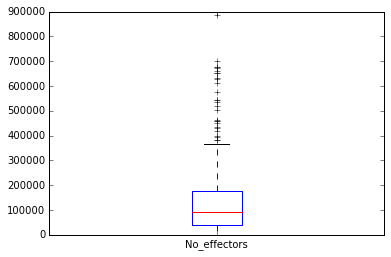

In [49]:
#non_effectors
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself = p_neself[p_neself > -1]
p_neself.name = 'No_effectors'
print(p_neself.describe())
p_neself.plot(kind='box')

look at the distribution of genes within a certain window

In [50]:
#some temp analysis on how many effectors are chained by a distance smaller than 20000.
#The chaining actually needs to be done with 5 and 3 prime
tmp_df = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe()

In [51]:
tmp_df_close= tmp_df [(tmp_df[12] < 20000) & (tmp_df[12] > -1) ]

In [52]:
tmp_df_close.loc[:, [3,9,12]]

,3,9,12
10,evm.TU.pcontig_001.124,evm.TU.pcontig_001.127,12738
11,evm.TU.pcontig_001.127,evm.TU.pcontig_001.124,12738
13,evm.TU.pcontig_001.197,evm.TU.pcontig_001.200,11620
14,evm.TU.pcontig_001.200,evm.TU.pcontig_001.197,11620
16,evm.TU.pcontig_001.395,evm.TU.pcontig_001.396,1418
17,evm.TU.pcontig_001.396,evm.TU.pcontig_001.395,1418
42,evm.TU.pcontig_004.154,evm.TU.pcontig_004.156,6767
43,evm.TU.pcontig_004.156,evm.TU.pcontig_004.154,6767
46,evm.TU.pcontig_004.364,evm.TU.pcontig_004.368,15611
47,evm.TU.pcontig_004.368,evm.TU.pcontig_004.364,15611


In [53]:
import seaborn as sns

No look a bit more into the distribution of the nearest neighbour distance

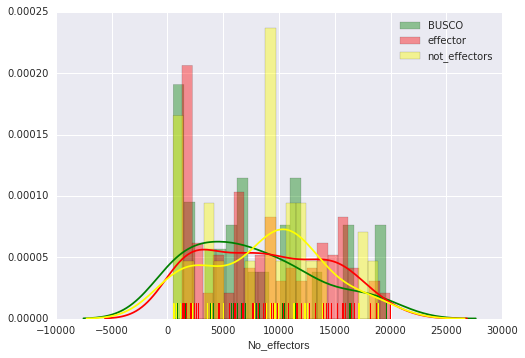

In [54]:
sns.distplot(p_bself[p_bself < 20000], bins=20, rug = True, color='g',label='BUSCO')
sns.distplot(p_eself[p_eself < 20000], bins=20, rug = True, color='red',label = 'effector')
sns.distplot(p_neself[p_neself <20000], bins=20, rug=True, color='yellow', label ='not_effectors')
plt.legend()

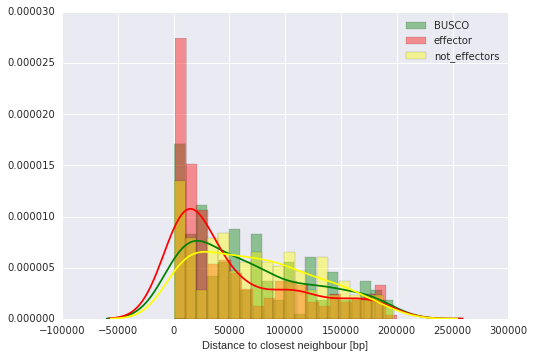

In [55]:
sns.distplot(p_bself[p_bself < 200000], bins=20, color='g' ,label='BUSCO')
sns.distplot(p_eself[p_eself < 200000], bins=20,  color='red',label = 'effector')
sns.distplot(p_neself[p_neself <200000], bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

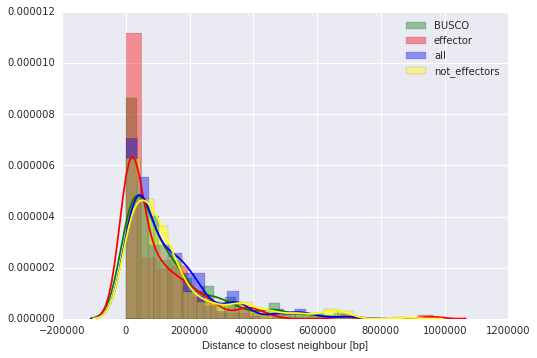

In [56]:
sns.distplot(p_bself, bins=20,color='g',  label='BUSCO')
sns.distplot(p_eself, bins=20,  color='red',label = 'effector')
sns.distplot(p_allall, bins=20,  color='b',label = 'all')
sns.distplot(p_neself, bins=20,  color='yellow', label ='not_effectors', axlabel='Distance to closest neighbour [bp]')
plt.legend()

In [57]:
#now make a nearest neightbour dataframe
nn_df = pd.concat([p_allall, p_bself, p_eself], names=['All_genes', 'BUSCO', 'effectors'], axis=1)

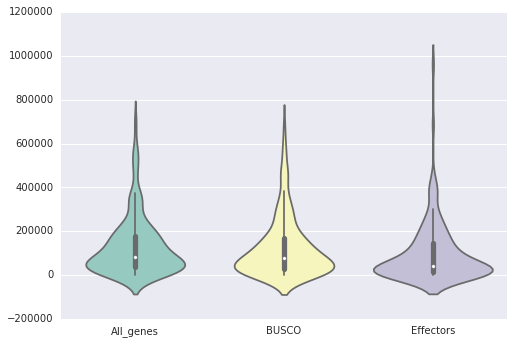

In [58]:
sns.violinplot(data=nn_df, palette="Set3")

In [59]:
#NOW FILTER BY QUANTIELS

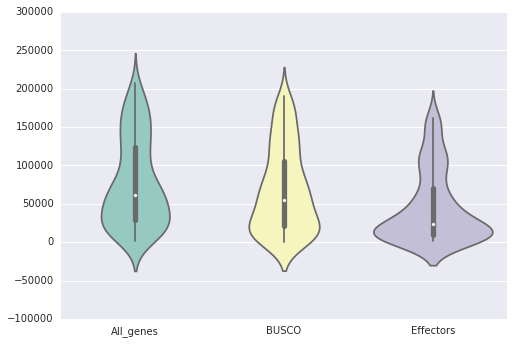

In [60]:
low = 0
high = 0.8
quant_df = nn_df.quantile([low,high])

qfilt_nn_df = nn_df.apply(lambda x: x[(x > quant_df.loc[low, x.name]) & (x  < quant_df.loc[high, x.name])], axis=0)

sns.violinplot(data=qfilt_nn_df , palette="Set3")

In [61]:
from scipy import stats

In [62]:
#now filter on IQR

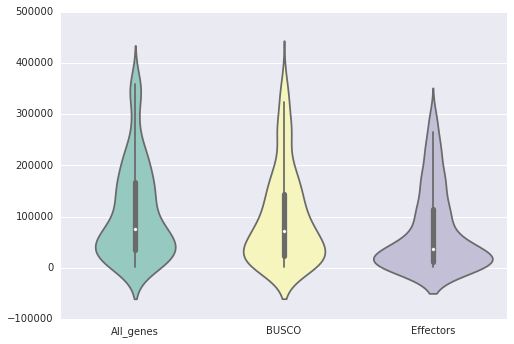

In [63]:
iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_low.name ='low'
iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_high.name = 'high'

iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)

sns.violinplot(data=iqr_nn_df  , palette="Set3")

In [64]:
#some more random ideas

55 104 46 38


(0, 20000)

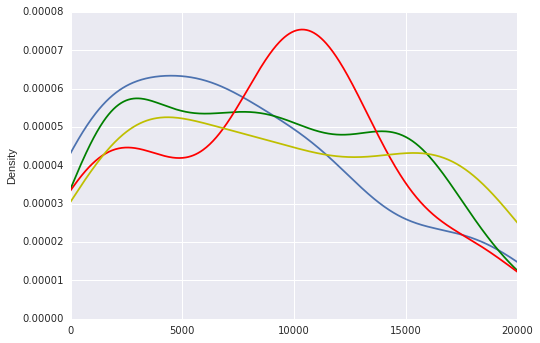

In [65]:
p_bself[p_bself < 20000].plot(kind='density')
p_eself[p_eself < 20000].plot(kind='density', color='g')
p_neself[p_neself < 20000].plot(kind='density', color='r')
p_eall[p_eall < 20000].plot(kind='density', color='y')
#plt.semilogx()
print(len(p_bself[p_bself < 20000]), len(p_eself[p_eself < 20000]), len(p_neself[p_neself < 20000]), len(p_eall[p_eall < 20000]))
plt.xlim(0, 20000)

(0, 0.0005)

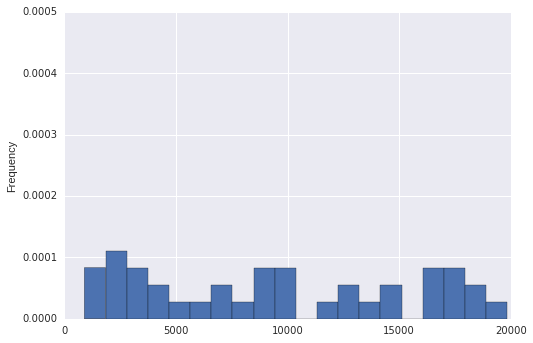

In [66]:
p_eall[p_eall < 20000].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00050)

(0, 0.0005)

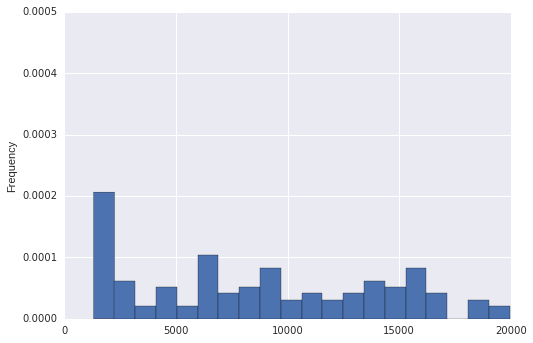

In [67]:
p_eself[p_eself < 20000].plot(kind='hist', bins=20, normed=True)
plt.ylim(0, 0.00050)

(0, 0.0005)

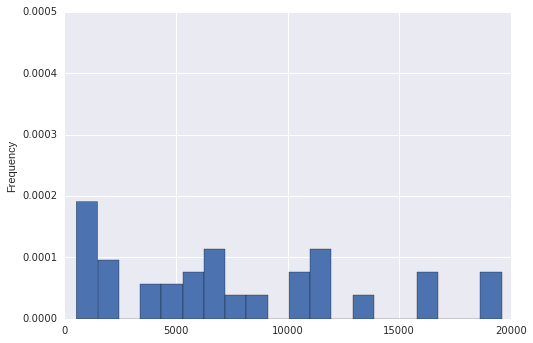

In [68]:
p_bself[p_bself < 20000].plot(kind='hist', bins=20,normed=True)
plt.ylim(0, 0.00050)

(0, 0.0005)

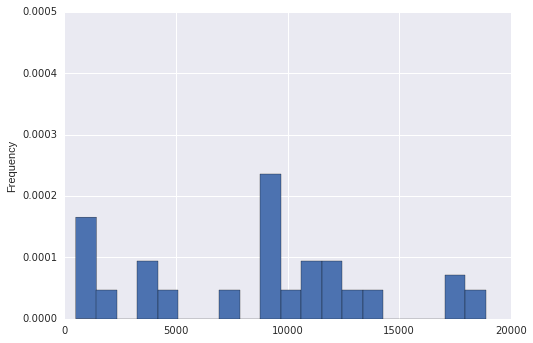

In [69]:
p_neself[p_neself < 20000].plot(kind='hist',bins=20,normed=True)
plt.ylim(0, 0.00050)

It seems like there seems to be no clear link between cluster 8 gens and closest neighbour in terms of TEs in general. They all have the same distance in general.
Maybe Gypsy and ClassII:?:? should be looked at more carefully. Those are depleted and enriched in busco and effector genes. In general there seems to be a trend towards ClassII elements compared to ClassI in effector candidates.


It seems that effectors are closer together than noneffector genes. Buscos also seem to cluster a bit. Let's see if we can visualize the location of genes on certain contigs vs repeats and such.

In [70]:
#start with getting effectors per contig divided by length divded by # of overall genes

In [71]:
#get effectors per contig
effector_bdf = pd.read_csv(p_effector_bed_fn, header=None, sep='\t')

p_effectors_per_contig  = effector_bdf.groupby(0).count()[1]
p_effectors_per_contig.name = 'effectors'

In [72]:
#get all others counts per contig
p_all_genes_per_contig = pd.read_csv(p_gene_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_all_genes_per_contig.name = 'all_genes'
p_noeffectors_per_contig = pd.read_csv(p_noeffector_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_noeffectors_per_contig.name = 'no_effectors'
p_busco_per_contig = pd.read_csv(p_busco_bed_fn, header=None, sep='\t').groupby(0).count()[1]
p_busco_per_contig.name = 'buscos'

In [73]:
#read in the genome file that contains the length of each contig in the second column
p_contig_length = pd.read_csv(os.path.join(GFF_FOLDER, 'Pst_104E_v12_p_ctg.genome_file'), header = None,\
                          names=['contig' , 'length'], sep='\t').sort_values('contig')

In [74]:
p_contig_length.index = p_contig_length.contig
p_contig_length = p_contig_length.loc[:, 'length']
#merge all series together in dataframe with the length as firts column
gene_dis_per_contig = pd.concat([p_contig_length,p_all_genes_per_contig,p_noeffectors_per_contig,p_busco_per_contig,\
                                 p_effectors_per_contig, ], axis = 1)

In [75]:
from scipy.stats import chisquare

In [76]:
#fill nan with 0s
gene_dis_per_contig.fillna(value=0, inplace=True)

In [77]:
gene_dis_per_contig.effectors.sum()

308.0

In [78]:
#chisquare for genes per contig vs bases per contig
chisquare(gene_dis_per_contig.length.values/gene_dis_per_contig.length.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

Power_divergenceResult(statistic=inf, pvalue=0.0)

In [79]:
chisquare(gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum()\
          , gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum())

Power_divergenceResult(statistic=nan, pvalue=nan)

In [80]:
#calculate the % of each category that are on a specific contig
gene_dis_per_contig['%busco'] = gene_dis_per_contig.buscos.values/gene_dis_per_contig.buscos.sum() *100
gene_dis_per_contig['%effector'] = gene_dis_per_contig.effectors.values/gene_dis_per_contig.effectors.sum() *100
gene_dis_per_contig['%all_genes'] = gene_dis_per_contig.all_genes.values/gene_dis_per_contig.all_genes.sum() *100
gene_dis_per_contig['%no_effector'] = gene_dis_per_contig.no_effectors.values/gene_dis_per_contig.no_effectors.sum() *100

In [81]:
#not sure why this isn't working
chisquare(gene_dis_per_contig['%effector'], f_exp = gene_dis_per_contig['%all_genes'])

Power_divergenceResult(statistic=nan, pvalue=nan)

In [82]:
#have a look at the different percentages
gene_dis_per_contig.loc[:,['%effector', '%all_genes','%no_effector' ,'%busco']]

,%effector,%all_genes,%no_effector,%busco
pcontig_000,2.60,3.66,3.68,3.67
pcontig_001,4.22,3.50,3.49,4.36
pcontig_002,3.57,3.07,3.06,2.49
pcontig_003,2.92,2.93,2.93,2.98
pcontig_004,2.27,2.33,2.33,2.22
pcontig_005,1.30,2.51,2.54,2.84
pcontig_006,3.57,2.70,2.68,3.32
pcontig_007,1.62,2.38,2.39,2.01
pcontig_008,0.97,1.95,1.97,1.80
pcontig_009,2.92,2.10,2.09,2.01


In [83]:
#contigs which % effectors is more than % of all genes or of buscos
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes']) &\
                    (gene_dis_per_contig['%effector'] > gene_dis_per_contig['%busco'])].loc[:,['effectors', '%effector', '%all_genes']].index

Index(['pcontig_002', 'pcontig_006', 'pcontig_009', 'pcontig_012',
       'pcontig_016', 'pcontig_018', 'pcontig_020', 'pcontig_021',
       'pcontig_023', 'pcontig_025', 'pcontig_026', 'pcontig_028',
       'pcontig_029', 'pcontig_033', 'pcontig_035', 'pcontig_036',
       'pcontig_037', 'pcontig_039', 'pcontig_040', 'pcontig_045',
       'pcontig_052', 'pcontig_057', 'pcontig_059', 'pcontig_064',
       'pcontig_066', 'pcontig_081', 'pcontig_083', 'pcontig_086',
       'pcontig_088', 'pcontig_091', 'pcontig_092', 'pcontig_129',
       'pcontig_149', 'pcontig_150'],
      dtype='object')

In [84]:
#effectors per contig > than expected 1.5 increase?
gene_dis_per_contig[((gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes']) > 1.5) & (gene_dis_per_contig['%effector'] > 0.9)]\
.loc[:,['effectors', '%effector', 'all_genes','%all_genes']].sort_values('effectors', ascending=False)

,effectors,%effector,all_genes,%all_genes
pcontig_016,10.00,3.25,279.00,1.75
pcontig_026,10.00,3.25,247.00,1.55
pcontig_023,9.00,2.92,251.00,1.58
pcontig_035,8.00,2.60,181.00,1.14
pcontig_037,8.00,2.60,188.00,1.18
pcontig_057,8.00,2.60,109.00,0.68
pcontig_045,5.00,1.62,145.00,0.91
pcontig_052,5.00,1.62,162.00,1.02
pcontig_059,5.00,1.62,107.00,0.67
pcontig_088,5.00,1.62,56.00,0.35


In [85]:
#sum off all effectors on enriched? contigs
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes'])].sum()

length         36093426.00
all_genes          7129.00
no_effectors       6917.00
buscos              671.00
effectors           212.00
%busco               46.47
%effector            68.83
%all_genes           44.76
%no_effector         44.28
dtype: float64

In [86]:
#effectors on enriched? contigs w/o filtering
gene_dis_per_contig[(gene_dis_per_contig['%effector'] > gene_dis_per_contig['%all_genes'])]\
    .loc[:,['effectors', '%effector', '%all_genes']].sort_values('effectors', ascending = False)

,effectors,%effector,%all_genes
pcontig_001,13.00,4.22,3.50
pcontig_006,11.00,3.57,2.70
pcontig_002,11.00,3.57,3.07
pcontig_016,10.00,3.25,1.75
pcontig_026,10.00,3.25,1.55
pcontig_020,9.00,2.92,1.97
pcontig_023,9.00,2.92,1.58
pcontig_009,9.00,2.92,2.10
pcontig_057,8.00,2.60,0.68
pcontig_037,8.00,2.60,1.18


In [87]:
#contigs enriched for busco genes with 1.2 folder over expected with more than 0.5% of all BUSCOS
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) & (gene_dis_per_contig['%busco'] > 0.5 )\
                    ].loc[:,['buscos', '%busco', '%all_genes']]

,buscos,%busco,%all_genes
pcontig_001,63.00,4.36,3.50
pcontig_006,48.00,3.32,2.70
pcontig_011,47.00,3.25,2.08
pcontig_022,32.00,2.22,1.70
pcontig_023,31.00,2.15,1.58
pcontig_030,26.00,1.80,1.43
pcontig_031,19.00,1.32,1.05
pcontig_037,25.00,1.73,1.18
pcontig_041,22.00,1.52,1.17
pcontig_042,21.00,1.45,1.10


In [88]:
#contigs enriched for busco genes with 1.2 folder over expected
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.2) \
                    ].loc[:,['buscos', '%busco', '%all_genes']]['buscos'].sum()

527.0

In [89]:
#enriched for effectors relative to busco and all genes. Seems to be the case that their might be contigs
#with less BUSCOs and more effectors
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%effector'] < 1) & \
                    (gene_dis_per_contig['%all_genes'] / gene_dis_per_contig['%effector'] < 1) ].sum()

length         30419236.00
all_genes          5985.00
no_effectors       5799.00
buscos              538.00
effectors           186.00
%busco               37.26
%effector            60.39
%all_genes           37.58
%no_effector         37.13
dtype: float64

In [90]:
#the trend is not as obvious the other way round
gene_dis_per_contig[(gene_dis_per_contig['%busco'] / gene_dis_per_contig['%all_genes'] > 1.0000001) & \
                   (gene_dis_per_contig['%effector'] / gene_dis_per_contig['%all_genes'] < 0.9999) ].sum()

length         23645025.00
all_genes          4623.00
no_effectors       4567.00
buscos              518.00
effectors            56.00
%busco               35.87
%effector            18.18
%all_genes           29.02
%no_effector         29.24
dtype: float64

Check if genes or TEs are the next closest to effectors

In [91]:
#get the REPET superfamily df and write out as bed fiel
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header).sort_values(['seqid','start'])
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start

tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'tmpsuperfamily.bed')
tmp_REPET[tmp_REPET.distance > 400].loc[:,['seqid', 'start', 'end', 'attributes', 'score', 'strand']].to_csv(tmp_fn, header=None, sep='\t', index=None)

p_repeats_bed = BedTool(tmp_fn)

In [92]:
#check if TE or gene is cloest to effectors
tmp_df = p_effector_bed.closest( [p_repeats_bed.fn,p_allgene_bed.fn] , mdb='all', d=True, N=True).to_dataframe()

tmp_df.rename(columns={10: 'ID'}, inplace=True)

print('Per of effectors having genes as closest %f' % (tmp_df[tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))

print('Per of effectors having TE as closest %f' % (tmp_df[~tmp_df.ID.str.contains('evm')][0].count()/len(p_effector_bed)*100))



Per of effectors having genes as closest 39.610390
Per of effectors having TE as closest 76.623377


Get 5 and 3 prime distances of genes

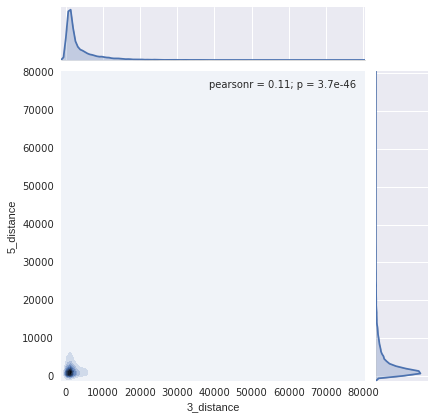

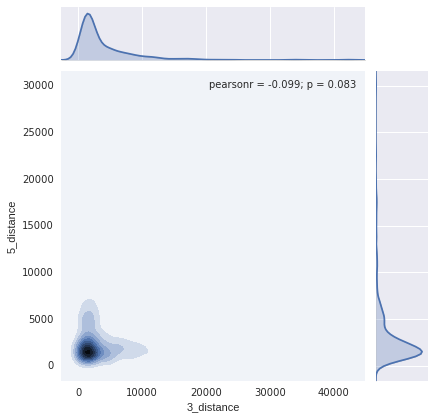

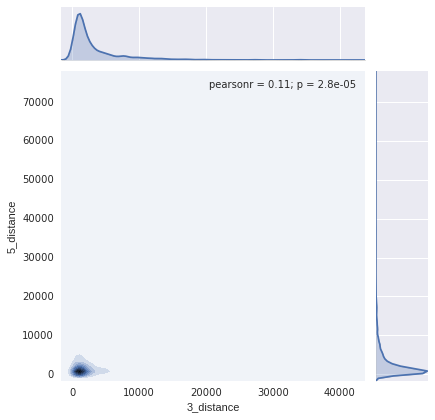

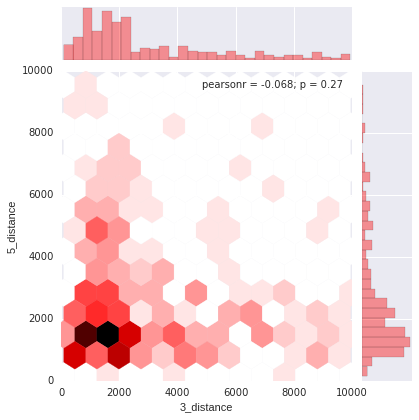

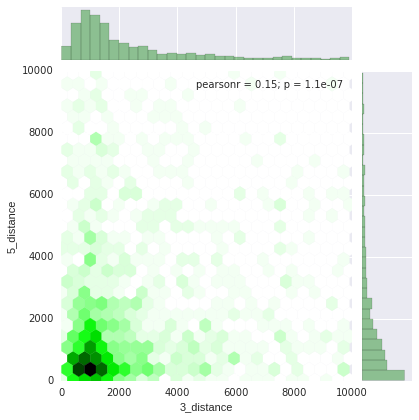

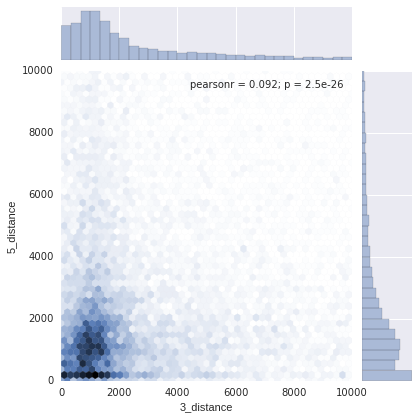

In [93]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
g_to_g_3 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]


g_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
g_to_g_5 = p_allgene_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
g_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

g_to_g_merged = g_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 and at the 3' end drop everything that has a negative distance meaning no 3' neighbour

g_to_g_merged = g_to_g_merged[ (g_to_g_merged['5_target'] !='.') &(g_to_g_merged['3_target'] !='.') ]


g_to_g_merged['5_distance'] = abs(g_to_g_merged['5_distance'])
g_to_g_merged['5_distance_log10'] = np.log10(g_to_g_merged['5_distance'])
g_to_g_merged['3_distance_log10'] = np.log10(g_to_g_merged['3_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde")



#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_g_3 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_g_5 = p_effector_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
e_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_g_merged = e_to_g_3.merge(g_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_g_merged = e_to_g_merged[((e_to_g_merged['5_target'] != '.') & ((e_to_g_merged['3_target'] != '.'))) ]
e_to_g_merged['5_distance'] = abs(e_to_g_merged['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde")


#now for busco
b_to_g_3 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
b_to_g_5 = p_busco_bed.closest( p_allgene_bed.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
b_to_g_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
b_to_g_merged = b_to_g_3.merge(b_to_g_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
b_to_g_merged = b_to_g_merged[((b_to_g_merged['5_target'] !='.') & (b_to_g_merged['3_target'] !='.')) ]
b_to_g_merged['5_distance'] = abs(b_to_g_merged['5_distance'])
sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged, kind="kde")

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)


#subset everything by fixed numbers maybe to IQR or such in future
sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged[(e_to_g_merged['5_distance'] < 10000) &\
        (e_to_g_merged['3_distance'] < 10000)], kind="hex", color='r',xlim=[0,10000], ylim=[0,10000],\
             marginal_kws=dict(bins=30))


sns.jointplot(x='3_distance', y='5_distance', data=b_to_g_merged[(b_to_g_merged['5_distance'] < 10000) &\
        (b_to_g_merged['3_distance'] < 10000)], kind="hex",color='g', xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged[(g_to_g_merged['5_distance'] < 10000) &\
        (g_to_g_merged['3_distance'] < 10000)], kind="hex", xlim=[0,10000], ylim=[0,10000],\
              marginal_kws=dict(bins=30))

Now look at the distance to the closest gene of the same group

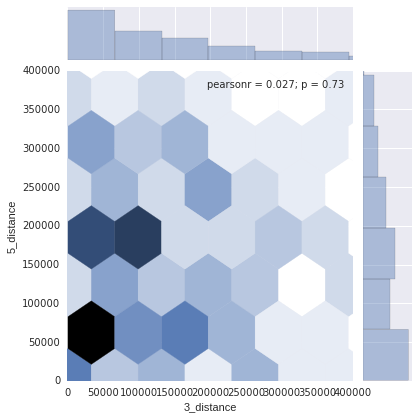

In [94]:
#now get the 3 prime distante to genes using the D='a' and iu flag in bedtools
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

all_all_rand_3 = p_allall_rand_sub.closest( p_allall_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]


all_all_rand_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)

#now get the 5 prime distante to genes using the D='a' and id flag in bedtools
all_all_rand_5 = p_allall_rand_sub.closest( p_allall_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
all_all_rand_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

all_all_rand_merged = all_all_rand_3.merge(all_all_rand_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account. Filter out everythign that has a 5' distance of -1 meaning nothing
#and is at the begining of the contig .1 <- the .1 was no appropriate here as the random subsampling can lead
#to alternative first gene models selected on the respective contig
#extended the initial df of closest to include also queyr and target. Now filtering on no target ='.' possible

all_all_rand_merged = all_all_rand_merged[((all_all_rand_merged['5_target'] != '.')&(all_all_rand_merged['3_target'] != '.')  ) ]



all_all_rand_merged['5_distance'] = abs(all_all_rand_merged['5_distance'])
all_all_rand_merged['5_distance_log10'] = np.log10(all_all_rand_merged['5_distance'])
all_all_rand_merged['3_distance_log10'] = np.log10(all_all_rand_merged['3_distance'])


sns.jointplot(x='3_distance', y='5_distance', data=all_all_rand_merged,xlim=[0,400000], ylim=[0,400000], kind="hex")



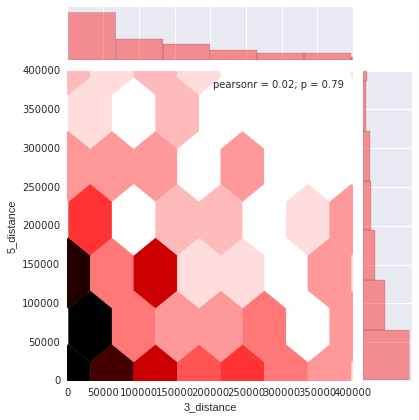

In [95]:
#do the same for effectors
#now for effectors 
#getting 5' and 3' distance
e_to_e_sub_3 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()\
    .iloc[:,[0, 3, 9,12]]
e_to_e_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_e_sub_5 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()\
    .iloc[:,[0, 3, 9,12]]
e_to_e_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

#merging them
e_to_e_sub_merged = e_to_e_sub_3.merge(e_to_e_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges
e_to_e_sub_merged = e_to_e_sub_merged [((e_to_e_sub_merged ['5_target'] != '.') & (e_to_e_sub_merged ['3_target'] != '.') )  ]
e_to_e_sub_merged ['5_distance'] = abs(e_to_e_sub_merged ['5_distance'])

sns.jointplot(x='3_distance', y='5_distance', data=e_to_e_sub_merged , xlim=[0,400000], ylim=[0,400000],kind="hex", color='red')


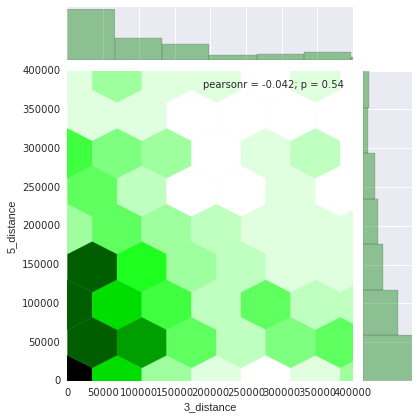

In [96]:

#now for busco
p_busco_bed_rand_sub_3 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
p_busco_bed_rand_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_5 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe().iloc[:,[0, 3, 9,12]]
p_busco_bed_rand_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_3.merge(p_busco_bed_rand_sub_5, on=['query', 'contig'])

#needs to be fixed to take boundaries into account
#remove genes on the edges see above for details
p_busco_bed_rand_sub_merged = p_busco_bed_rand_sub_merged[((p_busco_bed_rand_sub_merged['5_target'] != '.') & (p_busco_bed_rand_sub_merged['5_target'] != '.') )]
p_busco_bed_rand_sub_merged['5_distance'] = abs(p_busco_bed_rand_sub_merged['5_distance'])

#plot out
sns.jointplot(x='3_distance', y='5_distance', data=p_busco_bed_rand_sub_merged,xlim=[0,400000], ylim=[0,400000],\
              kind="hex" ,color = 'green')

#now start plotting stuff
#sns.jointplot(x='3_distance', y='5_distance', data=e_to_g_merged, kind="kde", color='r', xlim=10000, ylim=10000)
#sns.jointplot(x='3_distance', y='5_distance', data=g_to_g_merged, kind="kde", xlim=10000, ylim=10000)




In [97]:
#fixed up to here and closed as well.

Look into allele analysis below

In [98]:
allele_QC_fn = os.path.join('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis/alleles'\
                           , 'Pst_104E_v12_p_ctg.h_contig_overlap.Qcov80.PctID70.alleles')

allele_blast_df_fn = os.path.join('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/allele_analysis' ,'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis')

alleles_df = pd.read_csv(allele_QC_fn, header=None, sep = '\t', names=['p_protein', 'h_protein'])
alleles_df['match'] = alleles_df.p_protein + alleles_df.h_protein

allele_blast_df = pd.read_csv(allele_blast_df_fn, sep='\t')
allele_blast_df['match'] = allele_blast_df.Query + allele_blast_df.Target

allele_blast_df = allele_blast_df[(allele_blast_df.match.isin(alleles_df.match))]

len(allele_blast_df)

allele_blast_df.head()

print('Mean ID of effector alleles %f' % allele_blast_df[(allele_blast_df.Query.isin(p_effector_list))]['PctID'].mean())
print(len(allele_blast_df[(allele_blast_df.Query.isin(p_effector_list))])/len(p_effector_list))

print('Mean ID of non_effector alleles %f' % allele_blast_df[~(allele_blast_df.Query.isin(p_effector_list))]['PctID'].mean())
print(len(allele_blast_df)/len(p_allgene_bed))

print("Mean ID of busco allele %f" % allele_blast_df[(allele_blast_df.Query.\
                                isin(p_busco_bed.to_dataframe()['name'].str.replace('TU', 'model')))]['PctID'].mean()\
      )

print(len(allele_blast_df[(allele_blast_df.Query.\
                                isin(p_busco_bed.to_dataframe()['name'].str.replace('TU', 'model')))])/\
      len(p_busco_bed.to_dataframe()['name']))




Mean ID of effector alleles 97.823875
0.7792207792207793
Mean ID of non_effector alleles 98.216408
0.6452159718734304
Mean ID of busco allele 99.021836
0.7770083102493075


In [99]:
allele_blast_df[(allele_blast_df.Query.isin(p_busco_bed.to_dataframe()['name'].str.replace('TU', 'model')))]

,Query,Target,PctID,AlnLgth,NumMis,NumGap,StartQuery,StopQuery,StartTarget,StopTarget,...,BitScore,QLgth,QCov,q_contig,t_contig,q_contig == t_contig,p_protein,h_contig_overlap,t_contig == h_contig_overlap,match
97,evm.model.pcontig_000.11,evm.model.hcontig_000_003.12,100.00,543.00,0.00,0.00,1.00,543.00,1.00,543.00,...,1109.00,543,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.11,"['hcontig_000_003', 'hcontig_000_031']",True,evm.model.pcontig_000.11evm.model.hcontig_000_...
982,evm.model.pcontig_000.160,evm.model.hcontig_000_003.174,100.00,680.00,0.00,0.00,1.00,680.00,1.00,680.00,...,1402.00,680,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.160,['hcontig_000_003'],True,evm.model.pcontig_000.160evm.model.hcontig_000...
1196,evm.model.pcontig_000.166,evm.model.hcontig_000_003.180,99.61,254.00,1.00,0.00,1.00,254.00,1.00,254.00,...,509.00,254,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.166,['hcontig_000_003'],True,evm.model.pcontig_000.166evm.model.hcontig_000...
1340,evm.model.pcontig_000.178,evm.model.hcontig_000_003.192,97.56,287.00,6.00,1.00,1.00,286.00,46.00,332.00,...,567.00,286,100.35,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.178,['hcontig_000_003'],True,evm.model.pcontig_000.178evm.model.hcontig_000...
1348,evm.model.pcontig_000.18,evm.model.hcontig_000_003.19,100.00,1117.00,0.00,0.00,1.00,1117.00,1.00,1117.00,...,2320.00,1117,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.18,['hcontig_000_003'],True,evm.model.pcontig_000.18evm.model.hcontig_000_...
1478,evm.model.pcontig_000.204,evm.model.hcontig_000_003.215,100.00,625.00,0.00,0.00,1.00,625.00,1.00,625.00,...,1304.00,625,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.204,['hcontig_000_003'],True,evm.model.pcontig_000.204evm.model.hcontig_000...
1606,evm.model.pcontig_000.214,evm.model.hcontig_000_003.224,89.20,435.00,27.00,2.00,1.00,435.00,1.00,415.00,...,760.00,435,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.214,['hcontig_000_003'],True,evm.model.pcontig_000.214evm.model.hcontig_000...
1650,evm.model.pcontig_000.22,evm.model.hcontig_000_003.29,100.00,190.00,0.00,0.00,1.00,190.00,1.00,190.00,...,385.00,190,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.22,['hcontig_000_003'],True,evm.model.pcontig_000.22evm.model.hcontig_000_...
1651,evm.model.pcontig_000.220,evm.model.hcontig_000_003.230,100.00,522.00,0.00,0.00,1.00,522.00,1.00,522.00,...,1073.00,522,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.220,['hcontig_000_003'],True,evm.model.pcontig_000.220evm.model.hcontig_000...
1654,evm.model.pcontig_000.222,evm.model.hcontig_000_003.232,99.75,809.00,2.00,0.00,1.00,809.00,1.00,809.00,...,1661.00,809,100.00,pcontig_000,hcontig_000_003,True,evm.model.pcontig_000.222,['hcontig_000_003'],True,evm.model.pcontig_000.222evm.model.hcontig_000...


In [100]:
allele_blast_df.Query

0          evm.model.pcontig_000.10
2         evm.model.pcontig_000.100
4         evm.model.pcontig_000.101
6         evm.model.pcontig_000.102
8         evm.model.pcontig_000.103
10        evm.model.pcontig_000.104
11        evm.model.pcontig_000.105
13        evm.model.pcontig_000.108
55        evm.model.pcontig_000.109
97         evm.model.pcontig_000.11
102       evm.model.pcontig_000.110
104       evm.model.pcontig_000.111
105       evm.model.pcontig_000.112
124       evm.model.pcontig_000.115
389       evm.model.pcontig_000.116
390       evm.model.pcontig_000.117
405        evm.model.pcontig_000.12
440        evm.model.pcontig_000.13
466       evm.model.pcontig_000.132
469       evm.model.pcontig_000.133
470       evm.model.pcontig_000.134
472       evm.model.pcontig_000.135
474       evm.model.pcontig_000.136
808       evm.model.pcontig_000.137
809       evm.model.pcontig_000.138
816       evm.model.pcontig_000.139
818        evm.model.pcontig_000.14
830       evm.model.pcontig_

In [101]:
p_busco_bed.to_dataframe()['name'].str.replace('TU', 'model')

0        evm.model.pcontig_000.11
1        evm.model.pcontig_000.18
2        evm.model.pcontig_000.22
3        evm.model.pcontig_000.78
4        evm.model.pcontig_000.82
5        evm.model.pcontig_000.86
6       evm.model.pcontig_000.119
7       evm.model.pcontig_000.160
8       evm.model.pcontig_000.166
9       evm.model.pcontig_000.178
10      evm.model.pcontig_000.204
11      evm.model.pcontig_000.214
12      evm.model.pcontig_000.220
13      evm.model.pcontig_000.222
14      evm.model.pcontig_000.235
15      evm.model.pcontig_000.254
16      evm.model.pcontig_000.269
17      evm.model.pcontig_000.272
18      evm.model.pcontig_000.275
19      evm.model.pcontig_000.317
20      evm.model.pcontig_000.319
21      evm.model.pcontig_000.328
22      evm.model.pcontig_000.336
23      evm.model.pcontig_000.371
24      evm.model.pcontig_000.376
25      evm.model.pcontig_000.382
26      evm.model.pcontig_000.407
27      evm.model.pcontig_000.417
28      evm.model.pcontig_000.424
29      evm.mo